In [196]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from autoexperiment.template import generate_job_defs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

def get_samples_per_sec(path):
    all_vals = []
    data = open(path).readlines()
    for line in data:
        if "Train Epoch" in line:
            vals = re.findall("\d+\.\d*\/s,", line)
            vals = [float(v.replace("/s,", "")) for v in vals]
            all_vals.extend(vals)
    return np.mean(all_vals[1:])

In [197]:
model_profile = pd.read_csv("https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/model_profile.csv")
model_profile  = model_profile.set_index("model")

In [199]:
jobs = generate_job_defs("config.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']
results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
    for path in paths:
        data = json.load(open(path))
        dic = {
            'model': job.params['model'],
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
            "total_epochs": int(job.params["epochs"]),
            "name": job.params["name"],
            "gflops_total": model_profile.loc[job.params["model"]].gflops * job.params["epochs"] * job.params["train_num_samples"],
            "samples_per_sec": samples_per_sec,
            "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
            "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
            "training_time_hours": ((1/samples_per_sec) * job.params["epochs"] * job.params["train_num_samples"]) / 3600,
            "gpus": job.params["nodes"] * 4
        }
        dic.update(job.params)
        dic.update(data['metrics'])
        results.append(dic)
results = pd.DataFrame(results)

# Results

In [200]:
cols = [
    'model', 'samples_seen_scale', 'downstream_dataset', 
    "lr", "gflops_total", "siglip", "gpus", "batch_size", "global_batch_size", "samples_per_sec", 
    "training_time_hours", "name"
]

In [201]:
d = results[results.total_epochs==results.epoch]
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by=metric, ascending=False).round(4)

,acc1,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,name
314,0.5913,ViT-B-32,1.28B,wds/imagenet1k,0.0010,1.891840e+10,False,256,354,90624,213148.3302,1.6681,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
294,0.5653,ViT-B-32,1.28B,wds/imagenet1k,0.0010,1.891840e+10,True,256,354,90624,152083.8906,2.3379,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
274,0.5608,ViT-B-32,1.28B,wds/imagenet1k,0.0005,1.891840e+10,False,256,354,90624,212576.2874,1.6726,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
254,0.5408,ViT-B-32,1.28B,wds/imagenet1k,0.0005,1.891840e+10,True,256,354,90624,150823.7082,2.3574,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
234,0.3752,ViT-B-32,128M,wds/imagenet1k,0.0010,1.891840e+09,False,256,64,16384,83510.9708,0.4258,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
214,0.3595,ViT-B-32,128M,wds/imagenet1k,0.0010,1.891840e+09,True,256,64,16384,48774.9022,0.7290,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
194,0.3483,ViT-B-32,128M,wds/imagenet1k,0.0005,1.891840e+09,False,256,64,16384,83722.2685,0.4247,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
174,0.3368,ViT-B-32,128M,wds/imagenet1k,0.0005,1.891840e+09,True,256,64,16384,48849.7213,0.7279,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
114,0.0719,ViT-B-32,12.8M,wds/imagenet1k,0.0005,1.891840e+08,False,64,64,4096,25565.6708,0.1391,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigFalse
94,0.0605,ViT-B-32,12.8M,wds/imagenet1k,0.0005,1.891840e+08,True,64,64,4096,20597.0559,0.1726,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigTrue


In [202]:
d = results[results.total_epochs==results.epoch]

ds = 'wds/mscoco_captions'
metric = 'image_retrieval_recall@5'

d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by=metric, ascending=False).round(4)

,image_retrieval_recall@5,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,name
309,0.5189,ViT-B-32,1.28B,wds/mscoco_captions,0.0010,1.891840e+10,False,256,354,90624,213148.3302,1.6681,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
289,0.5053,ViT-B-32,1.28B,wds/mscoco_captions,0.0010,1.891840e+10,True,256,354,90624,152083.8906,2.3379,datacomp_s1.28B_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
269,0.4828,ViT-B-32,1.28B,wds/mscoco_captions,0.0005,1.891840e+10,False,256,354,90624,212576.2874,1.6726,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse
249,0.4733,ViT-B-32,1.28B,wds/mscoco_captions,0.0005,1.891840e+10,True,256,354,90624,150823.7082,2.3574,datacomp_s1.28B_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigTrue
229,0.3391,ViT-B-32,128M,wds/mscoco_captions,0.0010,1.891840e+09,False,256,64,16384,83510.9708,0.4258,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
209,0.3307,ViT-B-32,128M,wds/mscoco_captions,0.0010,1.891840e+09,True,256,64,16384,48774.9022,0.7290,datacomp_s128M_ViT-B-32_ep10_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
189,0.3134,ViT-B-32,128M,wds/mscoco_captions,0.0005,1.891840e+09,False,256,64,16384,83722.2685,0.4247,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigFalse
169,0.3071,ViT-B-32,128M,wds/mscoco_captions,0.0005,1.891840e+09,True,256,64,16384,48849.7213,0.7279,datacomp_s128M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs64_sigTrue
109,0.0787,ViT-B-32,12.8M,wds/mscoco_captions,0.0005,1.891840e+08,False,64,64,4096,25565.6708,0.1391,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigFalse
89,0.0680,ViT-B-32,12.8M,wds/mscoco_captions,0.0005,1.891840e+08,True,64,64,4096,20597.0559,0.1726,datacomp_s12.8M_ViT-B-32_ep10_lr0.0005_b1_0.9_b2_0.95_wd0.2_w100_gc1_n16_bs64_sigTrue


# Downstream Task Learning curves

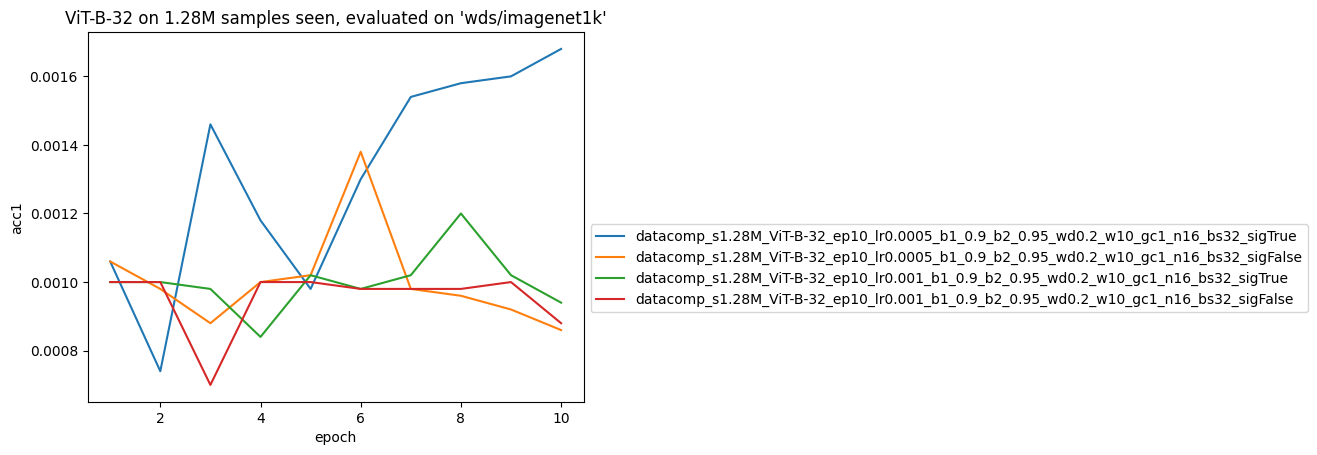

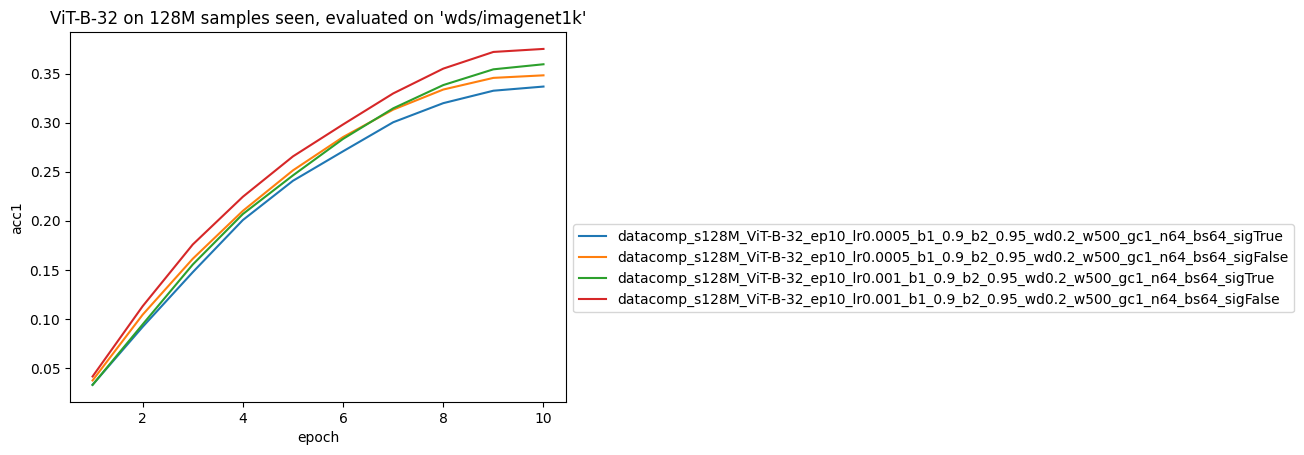

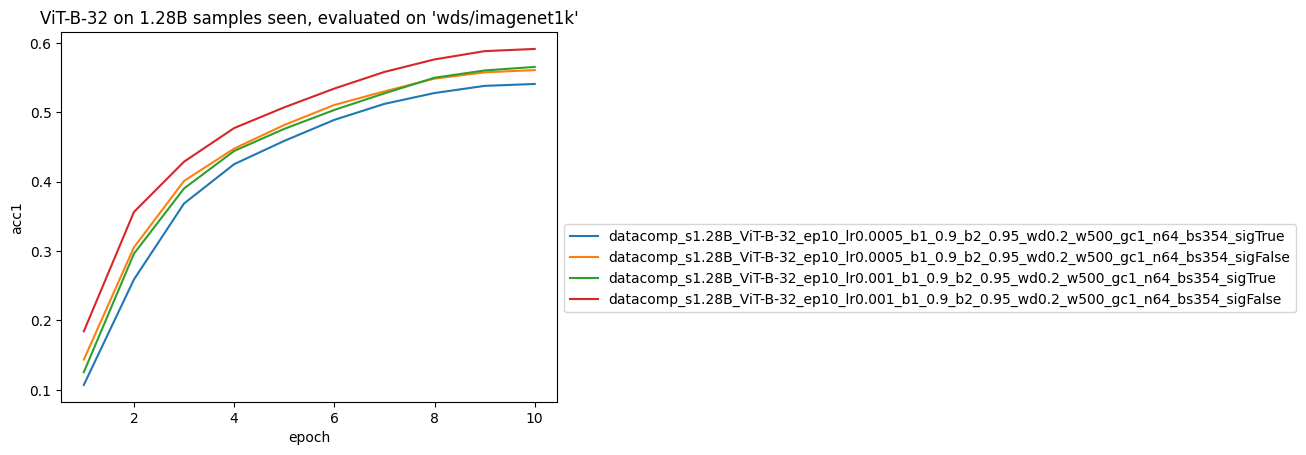

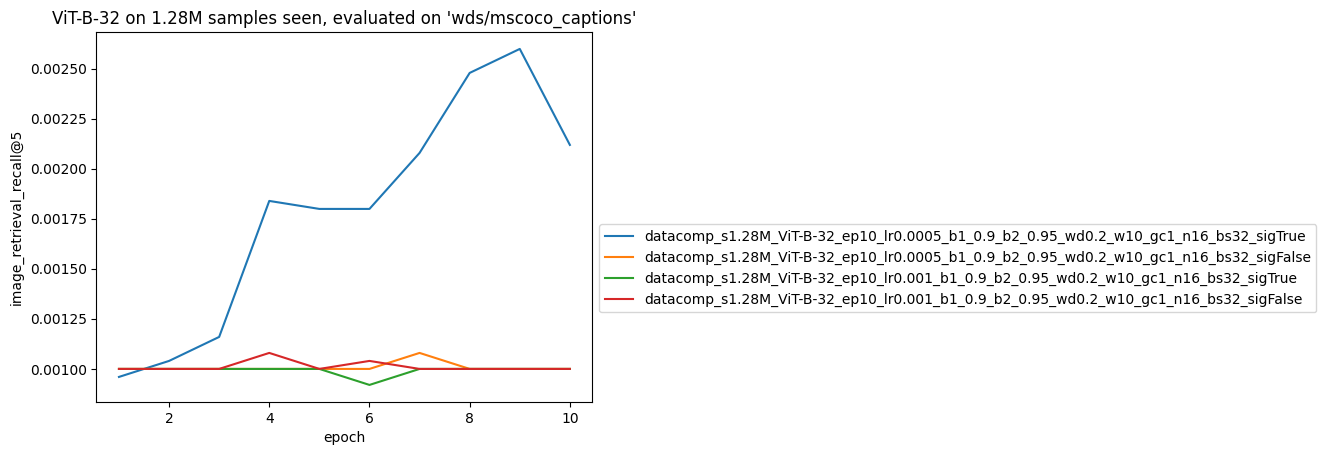

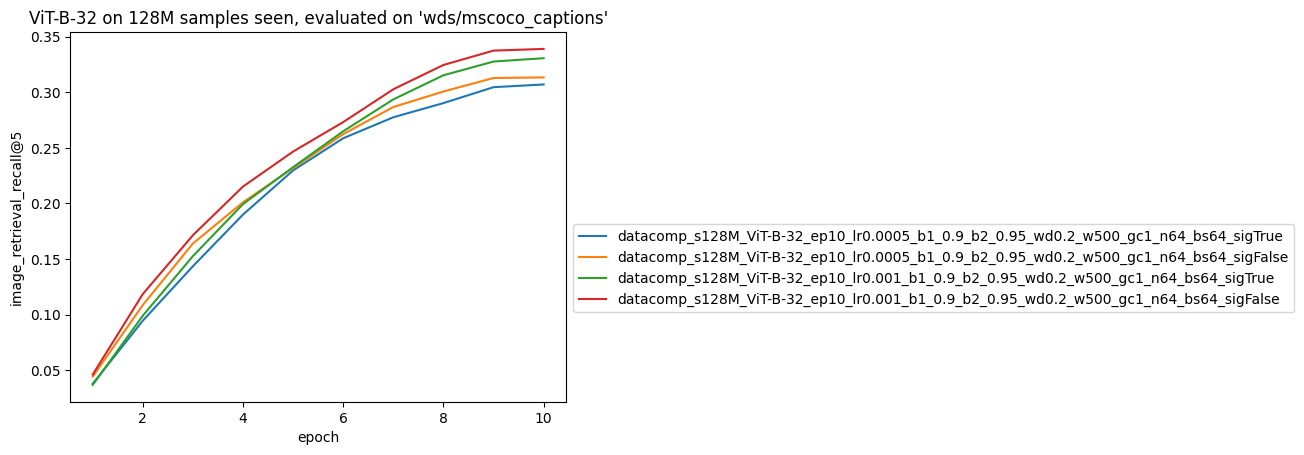

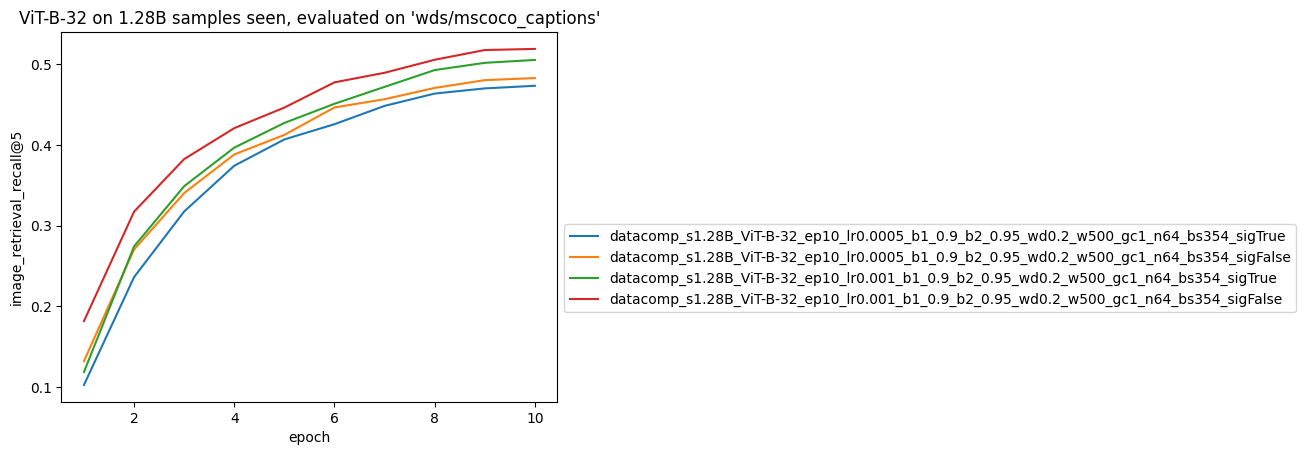

In [203]:
for model in ("ViT-B-32",):
    for (ds, metric) in ( ("wds/imagenet1k", "acc1"), ("wds/mscoco_captions", "image_retrieval_recall@5")):
        for samples_seen in ("1.28M", "128M", "1.28B"):
            d = results
            d = d[(d.model == model) & (d.samples_seen_scale==samples_seen) & (d.downstream_dataset==ds)]
            sns.lineplot(x="epoch", y=metric, data=d, hue="name")
            #d = d.sort_values(by='epoch')
            #d.plot(x='epoch', y=metric)
            plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{ds}'")
            plt.legend(bbox_to_anchor=(1,0.5))
            plt.show()

# Scaling curve

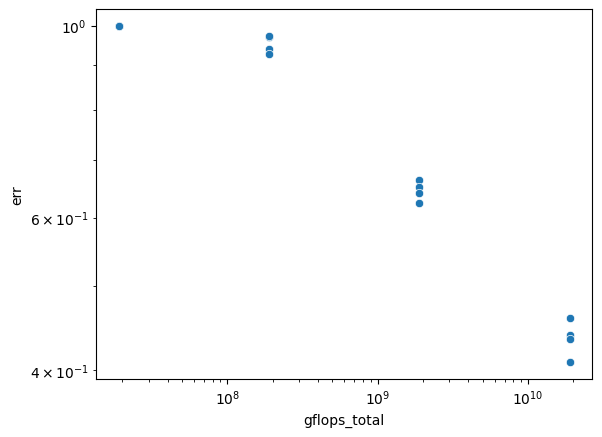

In [204]:
d = results[results.total_epochs==results.epoch]
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d["err"] = 1 - d[metric]
sns.scatterplot(x="gflops_total", y="err", data=d)
plt.xscale("log")
plt.yscale("log")